In [57]:
options(warn = -1)
options(repr.plot.width = 10, repr.plot.height = 8)

library(tidyverse)
library(sf)
library(dbscan)
library(gridExtra)
library(WeightIt)
library(cobalt)
library(pROC) 
library(survey) 
library(doParallel) 

setup_parallel <- function() {
  cores <- getOption("mc.cores", detectCores())  # CPU コア数を取得
  cl <- makeCluster(cores-1)  # クラスタ作成
  registerDoParallel(cl)  # 並列処理を登録
}

In [71]:

load <- readRDS("NTT_Data_norm_2021_2022_latest.rds")
data_int <- `load$data_integrated_norm_2021_2022`
data_soil <- load$data_integrated_norm_2021_2022


meta_int <- load$features_integrated_norm_2021_2022
meta_soil <- load$features_integrated_norm_2021_2022

v_cate <- unique(meta_int$Category)

# remove paired-field data
model_id <- read.csv("model_id.csv")$model_id
data_int_model <- data_int[data_int$Sample_ID %in% model_id,]
data_soil_model <- data_soil[data_soil$Sample_ID %in% model_id,]
data_int <- data_int[!data_int$Sample_ID %in% model_id,]
data_soil <- data_soil[!data_soil$Sample_ID %in% model_id,]


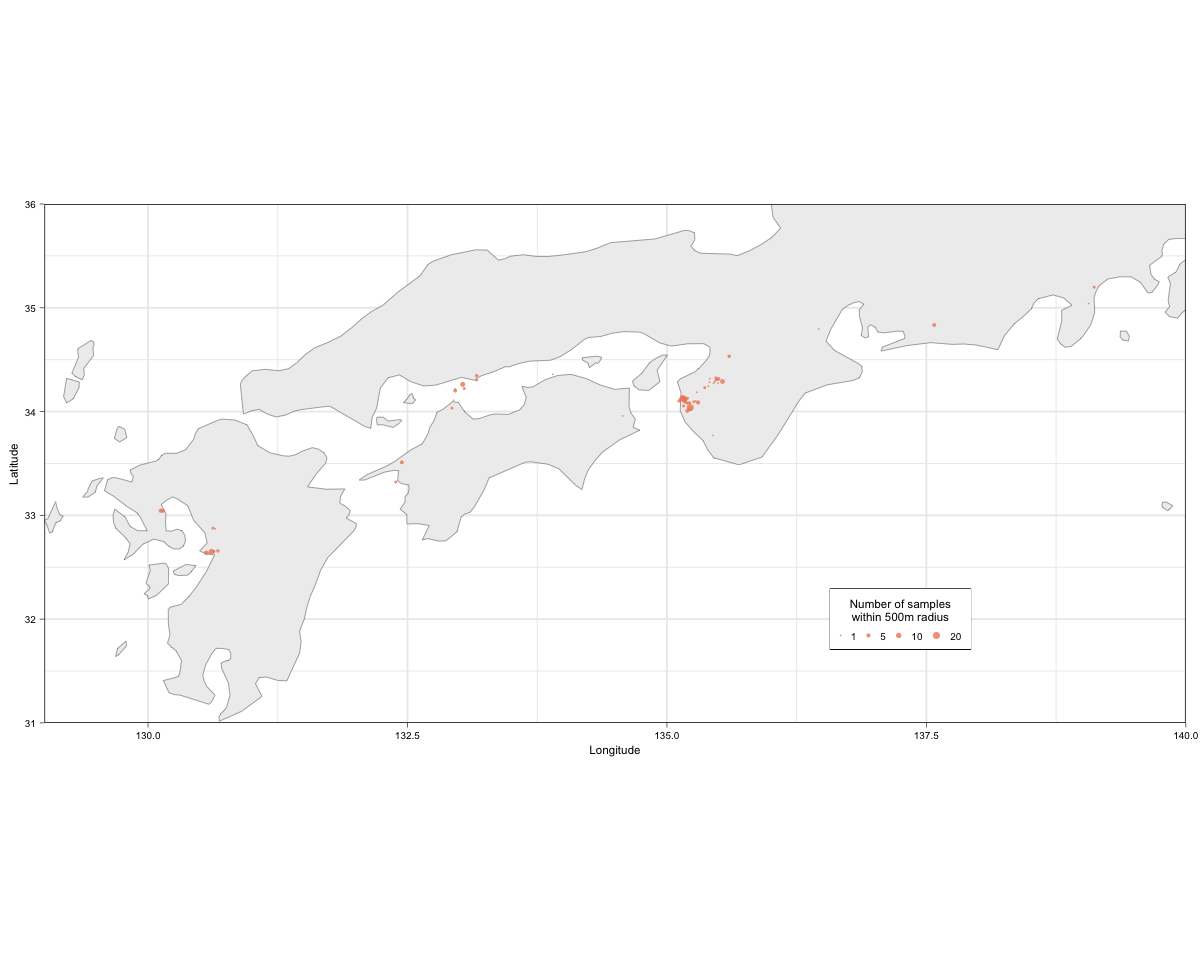

In [59]:
world <- ggplot2::map_data("world")
dat.Japan <- world %>% filter(region == "Japan")  %>% filter(subregion != "Haha Jima")
df <- data_soil[!is.na(data_soil$lati),]
data_sf <- st_as_sf(df, coords = c("long", "lati"), crs = 4326)
data_sf_projected <- st_transform(data_sf, crs = "+proj=aeqd +lat_0=35.6895 +lon_0=139.6917")
df$X <- st_coordinates(data_sf_projected)[, 1] / 500  # km単位
df$Y <- st_coordinates(data_sf_projected)[, 2] / 500  # km単位

epsilon <- 1# 半径の閾値
minPts <- 1
db <- dbscan(df[,c("X","Y")], eps = epsilon, minPts = minPts)
# print(max(db$cluster))
## 65

df <- cbind(df, geogroup=db$cluster)
df <- df %>%
  group_by(geogroup) %>% 
  reframe(count=length(lati), lati=mean(lati), long=mean(long))

g <- dat.Japan %>%  
  ggplot() + 
  geom_polygon(aes(x = long, y = lat, group = group),
               fill = "#EEEEEE", color = "black", size = 0.1) + 
  # coord_fixed(xlim = c(129, 140), ylim = c(31.5,35.5), expand = FALSE)+
  coord_fixed(xlim = c(129, 140), ylim = c(31,36), expand = FALSE)+
  geom_point(aes(x = long, y = lati, size = count),
             # colour = "#EE8866", alpha=1,
             colour = "#EE8866", alpha=0.8,
             shape=16, stroke=0,
             data = df) +
  scale_size_continuous(range = c(0.5, 2),
                        breaks = c(1, 5, 10, 20),
                        labels = c("1", "5", "10", "20"),
                        guide = guide_legend(order = 1)
                        )+
  labs(x="Longitude", y="Latitude", size="Number of samples\nwithin 500m radius")+ 
  # guides(size = guide_legend(nrow = 1))+
  theme_bw()+
  guides(size = guide_legend(nrow = 1))+
  theme(text = element_text(size=7, color="black"),
        axis.text = element_text(size=6, color="black"),
        axis.ticks = element_line(size=0.2),
        plot.margin = unit(c(1,3,1,2), "mm"),
        legend.position = c(0.75,0.2),
        legend.text = element_text(size=6, color="black"),
        legend.title.position = "top",
        legend.title = element_text(hjust=0.5),
        legend.box.background = element_rect(color = "black"),
        legend.box.spacing = unit(0,"mm"),
        legend.key.size = unit(0, "mm"),
        legend.key.spacing.y = unit(0,"mm"))

g

In [60]:
get_loveplot <- function(control, category, targets, data, meta) {

  pmat <- data[data$Category %in% c(control, category), meta$Category1 == "Sample"]
  vmat <- data[data$Category %in% c(control, category), meta$Category1 != "Sample"]
  vmat <- vmat %>% filter(!apply(pmat, 1, anyNA))
  pmat <- pmat %>% filter(!apply(pmat, 1, anyNA))
  
  options(na.action='na.pass')
  var <- model.matrix(coviriates, pmat)
  df <- data.frame(Category = factor(pmat$Category), 
                      as.data.frame(var))
  
  dependent_variable <- "Category"  
  independent_variables <- colnames(df)[colnames(df) != dependent_variable]
  formula_string <- paste(dependent_variable, "~", paste(independent_variables, collapse = " + "))
  
  invisible(capture.output(
    suppressMessages({
      weights <- weightit(as.formula(formula_string), data = df, method = "cbps")
    })
  ))
  
  m <- bal.tab(weights)
  mean_smd <- mean(abs(m$Balance$Diff.Adj[2:nrow(m$Balance)]))
  max_smd <- max(abs(m$Balance$Diff.Adj[2:nrow(m$Balance)]))
  
  df$w <- weights$weights
  propensity_scores <- weights$ps  # 重み付けモデルから取得
  true_labels <- df$Category  # 実際の処置ラベル（0 or 1）
  
  if (!is.null(propensity_scores)) {
    roc_obj <- roc(response = true_labels, predictor = propensity_scores)
    c_sta <- auc(roc_obj)
  } else {
    c_sta <- 0
  }

  df_weighted <- cbind(df, vmat)
  df_weighted$Category <- ifelse(df_weighted$Category == control, 0, 1)

  m <- bal.tab(weights, un = TRUE)
  return(abs(m$Balance[-1,-1]))
  
}

get_iptw <- function(control, category, targets, data, meta) {

  pmat <- data[data$Category %in% c(control, category), meta$Category1=="Sample"]
  vmat <- data[data$Category %in% c(control, category), meta$Category1!="Sample"]
  vmat <- vmat %>% filter(!apply(pmat,1,anyNA))
  pmat <- pmat %>% filter(!apply(pmat,1,anyNA))
  
  options(na.action='na.pass')
  var <- model.matrix(coviriates, pmat)
  df <- data.frame(Category = factor(pmat$Category), 
                      as.data.frame(var))
  
  dependent_variable <- "Category"  
  independent_variables <- colnames(df)[colnames(df) != dependent_variable]
  formula_string <- paste(dependent_variable, "~", paste(independent_variables, collapse = " + "))
  
  invisible(capture.output(
    suppressMessages({
      weights <- weightit(as.formula(formula_string), data = df, method = "cbps")
    })
  ))
  
  m <- bal.tab(weights)
  mean_smd <- mean(abs(m$Balance$Diff.Adj[2:nrow(m$Balance)]))
  max_smd <- max(abs(m$Balance$Diff.Adj[2:nrow(m$Balance)]))
  
  df$w <- weights$weights
  propensity_scores <- weights$ps  
  true_labels <- df$Category
  if (!is.null(propensity_scores)) {
    roc_obj <- roc(response = true_labels, predictor = propensity_scores)
    c_sta <- auc(roc_obj)
  } else {
    c_sta <- 0
  }
  
  df_weighted <- cbind(df, vmat)
  df_weighted$Category <- ifelse(df_weighted$Category == control, 0, 1)

  g <- love.plot(weights,
                 stats = "mean.diffs",
                 drop.distance = TRUE,
                 size = 1,
                 abs = TRUE, 
                 thresholds = c(0.25),
                 colors = c('#77AADD','#FFAABB'))+
    ggtitle(paste("Covariate balance between\n", control, "and", category))+
    theme(plot.title = element_text(size=6),
          axis.text = element_text(color = "black", size = 5),
          axis.title = element_text(color = "black", size = 6),
          axis.title.y =  element_blank(),
          axis.ticks = element_blank(),
          legend.position = "right",
          axis.line = element_line(linewidth = 0.2),
          panel.grid = element_line(linewidth = 0.2),
          legend.text = element_text(size = 5, color = "black", margin = margin(l = 1)),
          legend.title = element_text(size = 6, color = "black", margin = margin(b = 2)),
          legend.title.position = "top",
          legend.box.spacing = unit(0, "mm"),
          legend.key.size = unit(3, "mm")
          )+
    guides(color = guide_legend(ncol = 1))
  
  tests <- foreach (target = targets, .combine = "rbind", .packages = "survey") %dopar% {
    
    colnames(df_weighted)[colnames(df_weighted) == target] <- gsub("[^a-zA-Z0-9_]", "", target)
    target <- gsub("[^a-zA-Z0-9_]", "", target)
    outcome_formula <- as.formula(paste(target, "~ Category"))
    
    t <- table(df_weighted$Category[!is.na(df_weighted[target])])
    
    if ((length(t) > 1) & (all(t>2)))  {
      df_weighted[,target] <- scale(df_weighted[,target])

      svy_design <- svydesign(~1, weights = ~w, data = df_weighted[!is.na(df_weighted[target]),])
      svy_model <- svyglm(outcome_formula, design = svy_design)
      coef_estimate <- summary(svy_model)$coefficients[2, ]
      smd <- coef_estimate["Estimate"]
      p_value <- coef_estimate["Pr(>|t|)"]
      conf_int <- confint(svy_model, level = 0.95)[2, ]
    } else {
      smd <- NA
      p_value <- NA
      conf_int <- c(NA,NA)
    }
    return(c(smd, p_value, conf_int))
  }
  
  return(list(test = tests,
              loveplot = g,
              auc = c_sta,
              mean_smd =mean_smd,
              max_smd =max_smd))
}

In [61]:
targets <- c(colnames(data_soil)[meta_soil$Category=="Fruit_Quality"][1:8],
             colnames(data_soil)[meta_soil$Category=="Soil_Property"],
             colnames(data_soil)[meta_soil$Category=="Soil_Ion"],
             colnames(data_soil)[meta_soil$Category %in% c("Bacteria_Diversity","Fungi_Diversity")],
             "d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Nitrosomonadaceae;g__Nitrosomonas", 
             "d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Nitrosomonadaceae;g__Nitrosospira",
             "d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__Nitrospirales;f__Nitrospiraceae;g__Nitrospira",
             "d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Azospirillales;f__Azospirillaceae;g__Azospirillum",
             "d__Bacteria;p__Proteobacteria;c__Alphaproteobacteria;o__Rhizobiales;f__Xanthobacteraceae;g__Bradyrhizobium",
             "d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Pseudomonadaceae;g__Pseudomonas",
             "d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae;g__Bacillus",
             "d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Streptomycetales;f__Streptomycetaceae;g__Streptomyces",
             "k__Fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Glomus",
             "k__Fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Rhizophagus",
             "k__Fungi;p__Glomeromycota;c__Glomeromycetes;o__Glomerales;f__Glomeraceae;g__Funneliformis",
             "k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Hypocreales;f__Nectriaceae;g__Fusarium", #フザリウム萎凋病
             "k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Pleosporales;f__Pleosporaceae;g__Alternaria", #みかんの小黒点病
             "k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eurotiales;f__Aspergillaceae;g__Aspergillus", #こうじかび
             # "k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Capnodiales;f__Mycosphaerellaceae;g__Mycosphaerella",#そばかす病
             "k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eurotiales;f__Aspergillaceae;g__Penicillium", # 青カビ病,
             "k__Fungi;p__Ascomycota;c__Dothideomycetes;o__Capnodiales;f__Cladosporiaceae;g__Cladosporium",#すすはん病
             "k__Fungi;p__Ascomycota;c__Sordariomycetes;o__Glomerellales;f__Glomerellaceae;g__Colletotrichum", #炭疽病
             colnames(data_soil)[meta_soil$Category == "FAPROTAX"][c(29, 5, 10, 14, 50, 11,18,19, 3, 23, 22, 34, 49, 12, 7)]
             ,
             colnames(data_soil)[meta_soil$Category == "Bacteria_Genus"],
             colnames(data_soil)[meta_soil$Category == "Fungi_Genus"]
             )
targets <- targets[-which(duplicated(targets))]

Setting levels: control = C_Che_M_F_Hyb_M, case = C_Org_M_F_Org_M

Setting direction: controls < cases

Setting levels: control = C_Che_M_F_Hyb_M, case = C_Non_N_F_Non_N

Setting direction: controls < cases

Setting levels: control = C_Che_M_F_Hyb_M, case = C_Che_M_F_Org_M

Setting direction: controls < cases

Setting levels: control = C_Che_M_F_Hyb_M, case = C_Che_S_F_Org_S

Setting direction: controls < cases



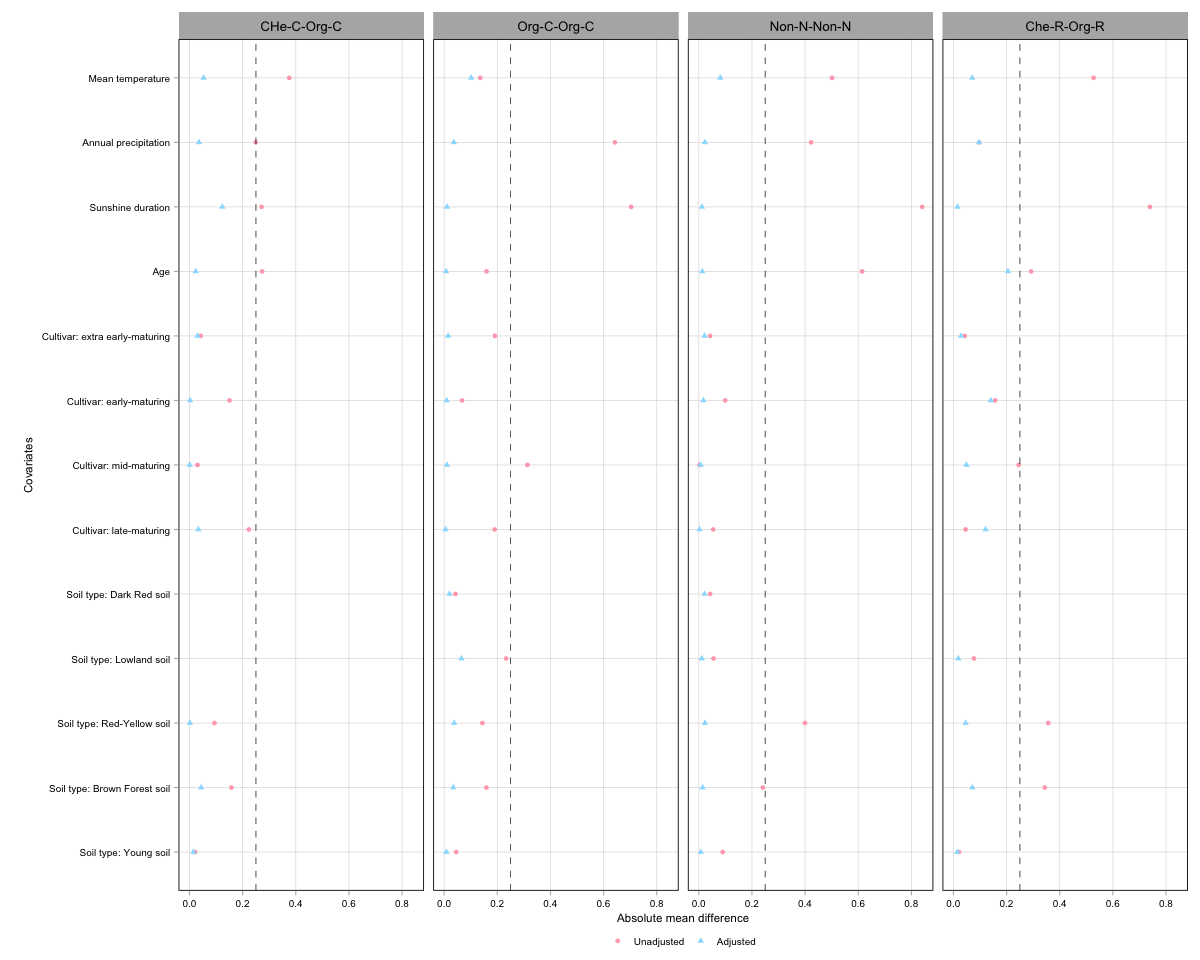

In [62]:
coviriates <- ~ TMP_mea + APCP + SSD + Age + Cultiver + Soil_Domestic_level1 - 1

control <- "C_Che_M_F_Hyb_M"
# t <- c("Org-C-Org-C","Non-N-Non-N","CHe-C-Org-C","Che-R-Org-R", "Che-R-Org-R","Che-R-Org-C","Non-N-Org-C")
tab <- sort(table(data_int$Category), decreasing = TRUE)
categories <- names(tab)[tab > 6][-match(control, names(tab)[tab > 6])]

result <- foreach(i = 1:4, .combine = "rbind") %do% {
    res <- get_loveplot(control, categories[i], targets, data_int, meta_int)
    cbind(covariate = rownames(res), data = rep(t[i], nrow(res)), res)
}

result <- pivot_longer(result, cols = 3:4)

result <- rbind(result,
                c("Soil_Domestic_level1E", "CHe-C-Org-C", "Diff.Un",NA),
                c("Soil_Domestic_level1E", "CHe-C-Org-C", "Diff.Adj",NA),
                c("Soil_Domestic_level1F", "CHe-C-Org-C", "Diff.Adj",NA),
                c("Soil_Domestic_level1F", "CHe-C-Org-C", "Diff.Adj",NA),
                c("Soil_Domestic_level1E", "Che-R-Org-R", "Diff.Adj",NA),
                c("Soil_Domestic_level1E", "Che-R-Org-R", "Diff.Adj",NA)
                )
result$value <- as.numeric(result$value)
result$covariate <- factor(result$covariate, levels = rev(unique(result$covariate)))

result$name <- factor(result$name, levels = c("Diff.Un", "Diff.Adj"),
                      labels = c("Unadjusted", "Adjusted"))

result$covariate <- factor(result$covariate,
                           levels = rev(unique(result$covariate)),
                           labels = rev(c("Mean temperature", "Annual precipitation", "Sunshine duration", "Age", "Cultivar: extra early-maturing", "Cultivar: early-maturing", "Cultivar: mid-maturing", "Cultivar: late-maturing", "Soil type: Dark Red soil", "Soil type: Lowland soil", "Soil type: Red-Yellow soil", "Soil type: Brown Forest soil", "Soil type: Young soil")))

result$data <- factor(result$data, levels = c("CHe-C-Org-C","Org-C-Org-C","Non-N-Non-N","Che-R-Org-R"))

ggplot(result, aes(covariate, value, color=name, shape=name))+
  geom_point(size=1)+
  geom_hline(yintercept = 0.25, size=0.2, linetype="dashed")+
  labs(x="Covariates", y="Absolute mean difference")+
  scale_color_manual(values=c("#FFAABB","#99DDFF"))+
  facet_grid(cols = vars(data), scales="free_y")+
  coord_flip()+
  theme_light()+
  theme(
    strip.text = element_text(size = 8, color = "black"),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(linewidth = 0.2),
    axis.line.y = element_blank(),
    axis.line.x = element_blank(),
  	panel.border = element_rect(color = "black", linewidth = 0.5),
    axis.text = element_text(size = 6, color = "black"),
    axis.title =  element_text(size = 7, color = "black"),
    axis.ticks = element_line(linewidth = 0.3),
    axis.line = element_line(linewidth = 0.3),
    panel.grid.major.x = element_line(),
    plot.title = element_blank(),
    plot.margin = unit(c(0.5, 0.5, 0.5, 1), "lines"),
    legend.box.margin = margin(0, 0, 0, 0, unit = "mm"),
    legend.margin = margin(-5, 0, 0, 0),
    legend.position = "bottom",
    legend.text = element_text(size = 6, color = "black"),
    legend.title = element_blank(),
    legend.key.size = unit(3, "mm")
    )

In [66]:
setup_parallel()

result <- foreach(category = categories[1:4], .combine = "cbind") %do% {
  
    res <- get_iptw(control, category, targets, data_soil, meta_soil)
    invisible(print(paste(category, ", AUC:", round(res$auc,3), ", MSD: ",round(res$max_smd,3), sep="")))
    if (res$max_smd < 0.25) {
      res$test
    } else {
      matrix(NA, nrow=length(targets), ncol=4)
    }
} %>% data.frame()

colnames(result) <- rep(categories[1:4], each = 4)
rownames(result) <- meta_soil$Name[match(targets, meta_soil$Feature)]

fdr <- apply(result[,seq(2, ncol(result), by=4)], 2, function(x) p.adjust(x, method="BH"))

result <- cbind(result[,1:4], fdr[,1],
                result[,5:8], fdr[,2],
                result[,9:12], fdr[,3],
                result[,13:16], fdr[,4]
                )

saveRDS(result, file = "cohort_ipw_result.rds")

Setting levels: control = C_Che_M_F_Hyb_M, case = C_Org_M_F_Org_M

Setting direction: controls < cases



[1] "C_Org_M_F_Org_M, AUC:0.892, MSD: 0.102"


Setting levels: control = C_Che_M_F_Hyb_M, case = C_Non_N_F_Non_N

Setting direction: controls < cases



[1] "C_Non_N_F_Non_N, AUC:0.869, MSD: 0.081"


Setting levels: control = C_Che_M_F_Hyb_M, case = C_Che_M_F_Org_M

Setting direction: controls < cases



[1] "C_Che_M_F_Org_M, AUC:0.821, MSD: 0.123"


Setting levels: control = C_Che_M_F_Hyb_M, case = C_Che_S_F_Org_S

Setting direction: controls < cases



[1] "C_Che_S_F_Org_S, AUC:0.885, MSD: 0.205"


In [64]:
load <- readRDS("NTT_Data_norm_2021_2022_latest.rds")
data <- load$data_integrated_norm_2021_2022
meta <- load$features_integrated_norm_2021_2022
ids <- read.csv("Experiment_ID.csv")

id <- c(ids$ID)[ids$Experiment == "Kainan" & !is.na(ids$Replicate) & ids$Sample == "fruit"]

df <- left_join(data[data$Sample_ID %in% id, ], ids[, -c(4,5)], by=c("Sample_ID" = "ID"))

df$Category <- ifelse(df$Category == "C_Che_M_F_Hyb_M", 0, 1)
df$Year <- ifelse(df$Year == "2021", 0, 1)

setup_parallel()

v2 <- foreach(i = 1:length(targets), .combine = "rbind", .packages = c("tidyverse", "broom", "lmerTest")) %dopar% {
    target <- targets[i]
    t <- table(df$Category[!is.na(df[target])])
    
    if ((length(t) > 1) & (all(t>2)))  {
      colnames(df)[colnames(df)==target] <- gsub("[^a-zA-Z0-9_]", "", target)
      target <- gsub("[^a-zA-Z0-9_]", "", target)
      
      if (all(t>3)) {
        df[,target] <- scale(df[,target])
        formula <- as.formula(paste(target, "~ Category + Year + (1 | Replicate)"))
        model <- lmer(formula, data = df, na.action = na.omit)
        conf_int <- confint(model, level = 0.95)[4, ]
        test <- summary(model)$coefficient[2, c(1, 5)]
      } else {
        test <- c(NA, NA)
        conf_int <- c(NA, NA)
      }
      c(test, conf_int)
    } else {
      c(NA, NA, NA, NA)
    }

} %>% data.frame()


rownames(v2) <- meta$Name[match(targets, meta$Feature)]
colnames(v2) <- c("Effect", "pvalue", "ci_lower", "ci_upper")

v2$fdr <- p.adjust(v2$pvalue, method = "BH")

saveRDS(v2, file = "NTT_model_Kainan_result.rds")


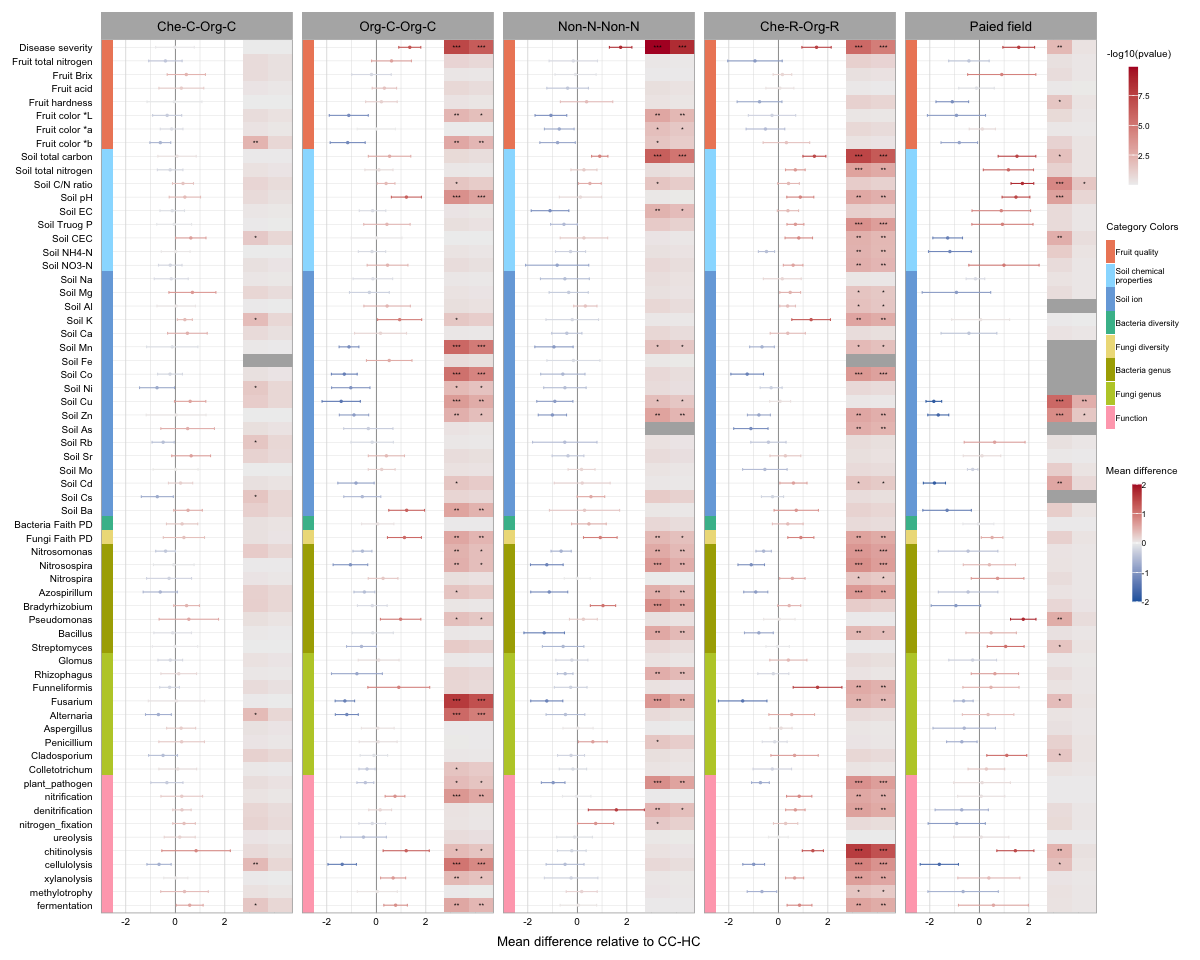

In [67]:
library(grid)

cohort_result <- readRDS("cohort_ipw_result.rds")
n <- colnames(cohort_result)
colnames(cohort_result) <- rep(c("Effect","pvalue","ci_lower","ci_upper","FDR"),4)

model_result <- readRDS("NTT_model_Kainan_result.rds")
colnames(model_result) <- c("Effect","pvalue","ci_lower","ci_upper","FDR")

x <- data.frame(target = meta_soil$Name[match(targets, meta_soil$Feature)], 
                type = meta_soil$Category[match(targets,meta_soil$Feature)])

df <- cbind(x, name = rep(n[1], nrow(x)), cohort_result[, 1:5]) %>%
  rbind(cbind(x, name = rep(n[6], nrow(x)), cohort_result[, 6:10])) %>%
  rbind(cbind(x, name = rep(n[11], nrow(x)), cohort_result[, 11:15])) %>%
  rbind(cbind(x, name = rep(n[16], nrow(x)), cohort_result[, 16:20])) %>%
  rbind(cbind(x, name = rep(paste(n[16]," (paired)", sep = ""), nrow(x)), model_result))

rownames(df) <- NULL

df <- df[df$target %in% unique(df$target)[1:69][-c(18, 37, 38, 40, 41)],]
x <- x[x$target %in% unique(x$target)[1:69][-c(18, 37, 38, 40, 41)],]

df$signif_p <- ifelse(df$pvalue > 0.05, "",
                             ifelse(df$pvalue > 0.01, "*",
                                    ifelse(df$pvalue > 0.001, "**", "***"))) 
df$signif_fdr <- ifelse(df$FDR > 0.05, "",
                             ifelse(df$FDR > 0.01, "*",
                                    ifelse(df$FDR > 0.001, "**", "***"))) 
  
df$target <- factor(df$target, levels = rev(unique(df$target))[c(1:62, 64, 63)])
x$target <- factor(x$target, levels = rev(x$target)[c(1:62, 64, 63)])

name_colors <- c("CC-OC" = '#77AADD', "OC-OC" = '#99DDFF', "CR-OR" = '#BBCC33', "NN-NN" = '#EEDD88')
df$name <- factor(df$name,
                  levels=c("C_Che_M_F_Org_M", "C_Org_M_F_Org_M", "C_Non_N_F_Non_N", "C_Che_S_F_Org_S", "C_Che_S_F_Org_S (paired)"),
                  labels=c("Che-C-Org-C", "Org-C-Org-C", "Non-N-Non-N", "Che-R-Org-R","Paied field"))

x$type <- factor(x$type, levels=rev(unique(x$type)),
                 labels = c("Function", "Fungi genus", "Bacteria genus", "Fungi diversity", "Bacteria diversity", "Soil ion", "Soil chemical\nproperties", "Fruit quality"))

pal <- c('#FFAABB','#BBCC33','#AAAA00','#EEDD88','#44BB99','#77AADD', '#99DDFF','#EE8866')

g <- ggplot(df)+
    geom_hline(yintercept = 0, linewidth = 0.1)+
    geom_errorbar(aes(x = target,  color = Effect, ymin = ci_lower, ymax = ci_upper), 
                  position = position_dodge(width = 0.75),
                  width = 0.2, size = 0.3)+
    scale_color_gradient2(limits = c(-2, 2),
      low = "#2166ac",mid = "#EEEEEE",high = "#b2182b", na.value = "#B0B0B0")+
    scale_y_continuous(limits=c(-3, 4.75), expand = c(0, 0), breaks = seq(-2, 2, by = 2))+
    geom_point(aes(x=target,  color=Effect, y=Effect), position = position_dodge(width = 0.75), size = 0.3)+
    geom_tile(aes(x = target, y = 3.25, fill = -log10(pvalue)), width = 1, height = 1) +
    geom_tile(aes(x = target, y = 4.25, fill = -log10(FDR)), width = 1, height = 1) +
    geom_text(aes(x = target, y = 3.25, label = signif_p), vjust = 0.6, size = 1.5)+
    geom_text(aes(x = target, y = 4.25, label = signif_fdr), vjust = 0.6, size = 1.5)+
    scale_fill_gradient(high = "#b2182b", low = "#EEEEEE", na.value = "#B0B0B0")+
    facet_grid(cols = vars(name), scales = "free_y")+
    labs(y = "Mean difference relative to CC-HC", color = "Mean difference")+
    coord_flip()+
    theme_light()+
    theme(axis.text = element_text(size = 6, color = "black"),
          axis.text.x = element_text(vjust = 3),
          axis.title =  element_text(size = 8, color = "black"),
          axis.title.y =  element_blank(),
          axis.ticks = element_blank(),
          plot.title = element_blank(),
          panel.grid.major.y = element_line(size = 0.1),
          strip.text = element_text(size = 8, color = "black"),
          plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "lines"),
          legend.title.position = "top",
          legend.position = "right",
          legend.justification = c(2, 1),
          legend.box.margin = margin(0, 0, 0, 0, unit = "mm"),
          legend.text = element_text(size = 5, color = "black", margin = margin(l = 0)),
          legend.title = element_text(size = 6, color = "black", hjust = 0.5),
          legend.key.width = unit(2, "mm"),
          legend.key.height = unit(5, "mm"),
          legend.box.spacing = unit(0, "mm"),
    )+
    ggnewscale::new_scale_fill() +
    geom_tile(data = x,
              aes(x = target, y = -2.75, fill = type),
              width = 1.1, height = 0.5)+
    scale_fill_manual(name = "Category Colors", values = pal)+
    guides(fill = guide_legend(reverse = TRUE))
g